In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import time
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

%matplotlib inline
import re

import ipyparallel as ipp
import scipy.stats as stats
import sys, gc
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine, text
from IPython.display import Image
from IPython.core.display import HTML 
from pandas import DataFrame

from pandas.plotting import register_matplotlib_converters
#pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000)
sqlalchemy.__version__

'1.4.51'

In [2]:
import locale
from locale import atof
locale.setlocale(category=locale.LC_ALL, locale="Russian")

'Russian_Russia.1251'

In [3]:
db_config = {
    'user': 'postgres', # имя пользователя
    'pwd': 'Maxilab', # пароль
    'host': 'localhost',
    'port': 5432, # порт подключения
    'db': 'ALFA' # название базы данных
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

query =     '''
            EXPLAIN
            SELECT * 
            FROM clients
            ''' 
#ПРИМЕР КАК ПОСМОТРЕТЬ ПЛАН ЗАПРОСА
explain_clients = pd.read_sql_query(query, con = engine) 
explain_clients

QUERY PLAN
0  Seq Scan on clients  (cost=0.00..11.20 rows=120 width=646)

### поняла, что в 1-м и 4-м заданиях нужны временные таблицы - на фото ниже, то как я реализовала в Postgres, но для выполнения задания в таком формате мне это не подошло

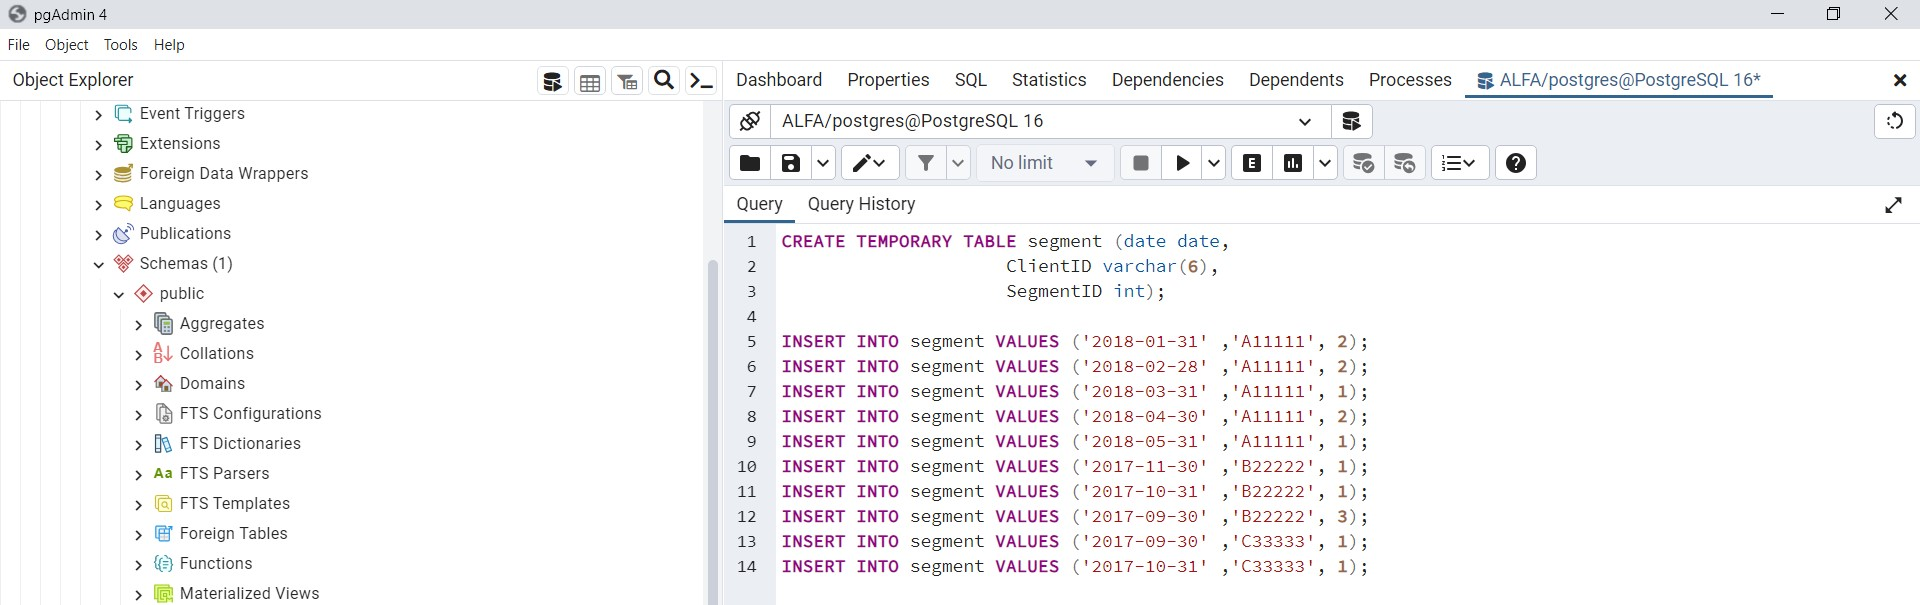

1. [**SQL**](#100)

Задание 1 (SQL)
* [1.1.Задание 1 (SQL).](#101)
* [1.1.1. Запрос для 1-го задания (SQL).](#1011)
* [1.2.Задание 2 (SQL).](#102)
* [1.2.1.Запрос для 2-го задания (SQL).](#1021)
* [1.3.Задание 3 (SQL).](#103)
* [1.3.1.Запрос для 3-го задания (SQL).](#1031)
* [1.4.Задание 4 (SQL).](#104)
* [1.4.1.Запрос для 4-го задания (SQL).](#1041)
2. [**Задание 2 - разметка и метрики.**](#200)
* [2.1.Ответ на 2-й вопрос.](#201)
3. [**Задание 3 - когортный анализ.**](#300)
* [3.1.Ответ на 3-й вопрос.](#301)
* [3.2.Выводы и рекомендации к 3-му вопросу.](#302)
3. [**Задание 4 - портфолио.**](#400)
* [4.1. 1 Проект.](#401)
* [4.2. 2 Проект.](#402)
* [4.3. 3 Проект.](#403)
* [4.4. 4 Проект.](#404)
* [4.5. 5 Проект.](#405)

## SQL <a id='100'></a>

### <font color='blue'>Задание 1 (SQL) <a id='101'></a>

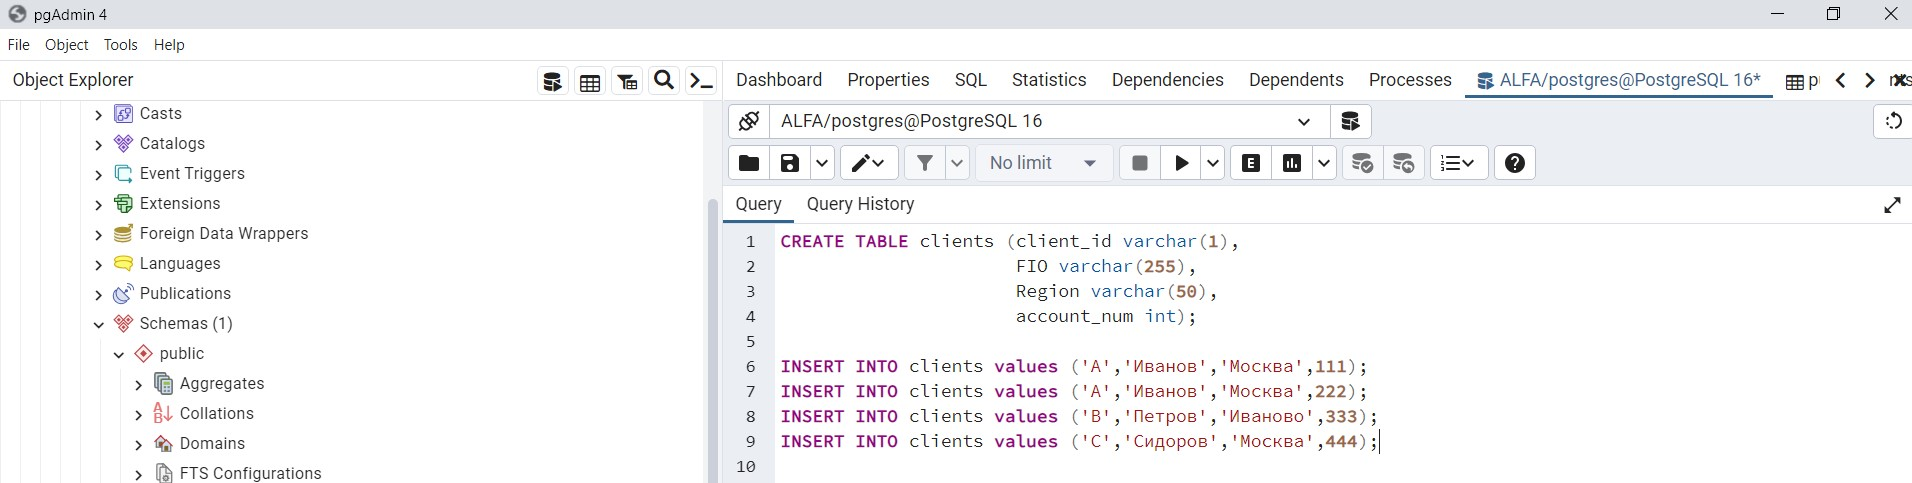

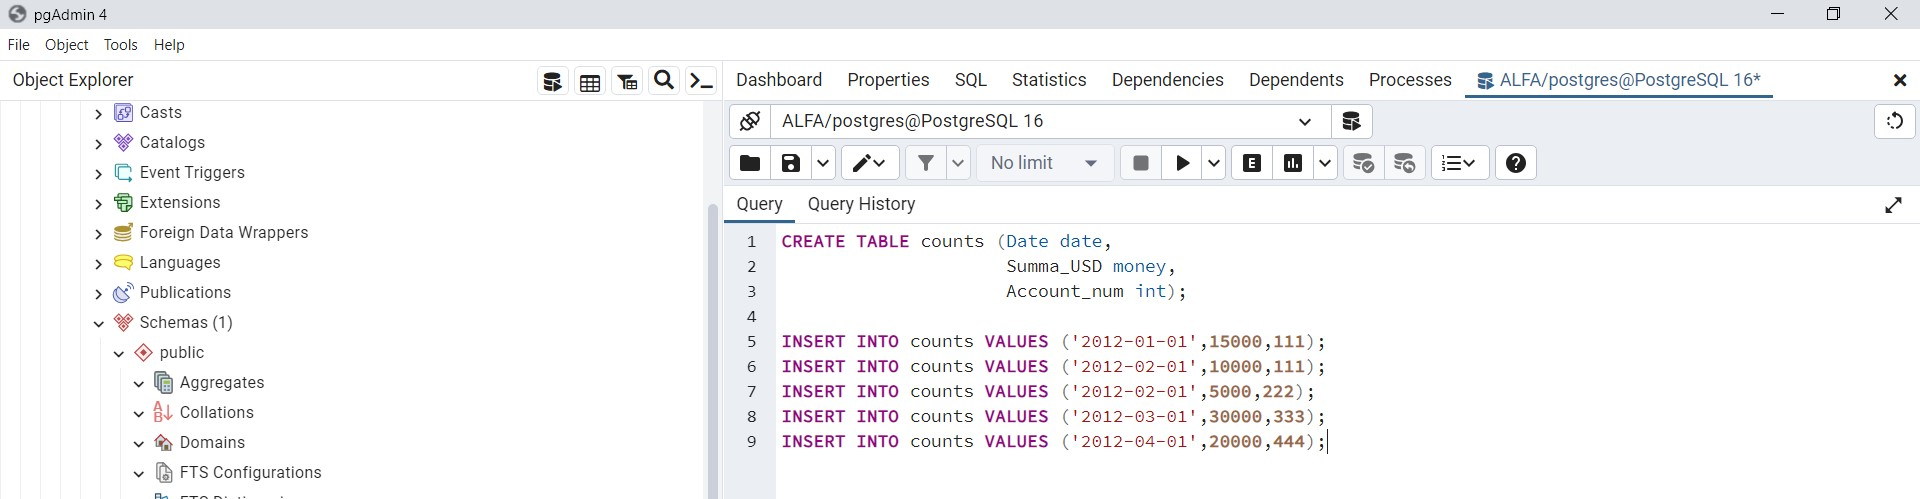

<font color='green'>**Отобрать клиентов по г. Москва с суммарными остатками по клиенту от 20 000 на последнюю дату.**</font>
____________________________

* create table #Клиенты (client_id varchar(1), FIO varchar (255) , Region varchar(50), account_num int)
* insert into #Клиенты values
* ('A','Иванов','Москва',111),
* ('A','Иванов','Москва',222),
* ('B','Петров','Иваново',333),
* ('C','Сидоров','Москва',444)
_____________________________
* create table #Cчета ([Date] date, Summa_USD money, Account_num int)
* insert into #Cчета values
* ('2012-01-01',15000,111),
* ('2012-02-01',10000,111),
* ('2012-02-01',5000,222),
* ('2012-03-01',30000,333),
* ('2012-04-01',20000,444)

In [4]:
%%time
with engine.begin() as conn:
    query = text("""SELECT * 
                    FROM clients""")
    c = pd.read_sql_query(query, conn)
c

CPU times: total: 0 ns
Wall time: 2 ms


client_id      fio   region  account_num
0         A   Иванов   Москва          111
1         A   Иванов   Москва          222
2         B   Петров  Иваново          333
3         C  Сидоров   Москва          444

In [5]:
%%time
with engine.begin() as conn:
    query = text("""SELECT * 
                    FROM counts""")
    cou = pd.read_sql_query(query, conn)
cou

CPU times: total: 31.2 ms
Wall time: 5 ms


date    summa_usd  account_num
0  2012-01-01  15 000,00 ?          111
1  2012-02-01  10 000,00 ?          111
2  2012-02-01   5 000,00 ?          222
3  2012-03-01  30 000,00 ?          333
4  2012-04-01  20 000,00 ?          444

## <font color='red'> запрос для 1-го задания SQL <a id='1011'></a>

In [6]:
%%time
with engine.begin() as conn:
    query = text("""WITH a1 AS(
                    --Преобразование типа money
                    SELECT date, 
                        REGEXP_REPLACE(TRIM(REPLACE(REPLACE(CAST(summa_usd AS varchar), '?', ''),\
                        ',', '.')), '\s', '', 'g')::FLOAT AS summa_usd,
                        account_num
                    FROM counts
                             )

                    SELECT c.client_id, c.fio, c.region, SUM(a1.summa_usd) AS total_sum
                    FROM clients c
                    JOIN a1 ON c.account_num = a1.account_num
                    WHERE c.region = 'Москва'
                    GROUP BY c.client_id, c.fio, c.region
                    HAVING MAX(a1.date) = (SELECT MAX(date) FROM a1) AND SUM(a1.summa_usd) >= 20000;
                """)
    rez1 = pd.read_sql_query(query, conn)
rez1

CPU times: total: 15.6 ms
Wall time: 6.05 ms


client_id      fio  region  total_sum
0         C  Сидоров  Москва    20000.0

____________________________________________________________________________

### <font color='blue'>Задание 2 (SQL) <a id='102'></a>

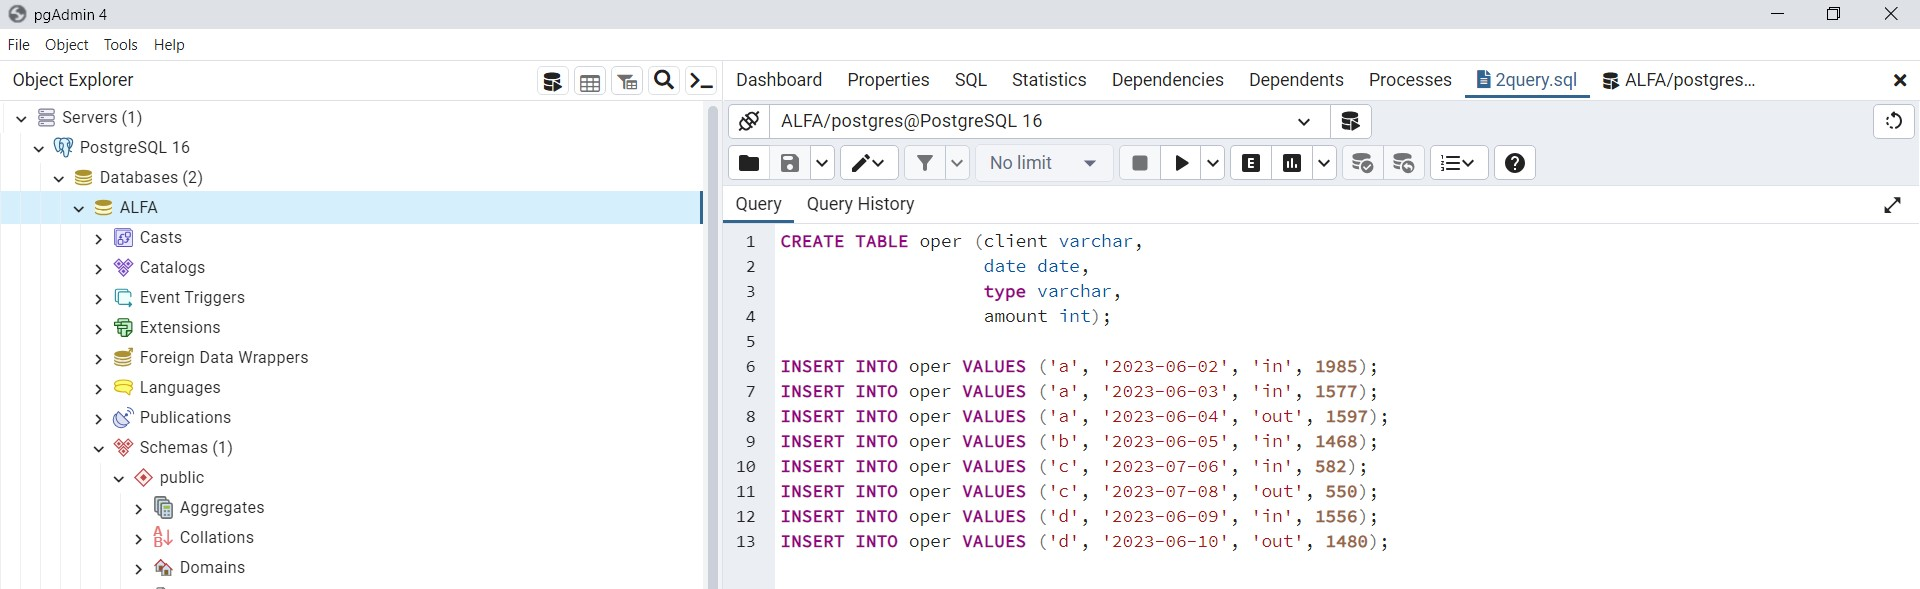

<font color='green'>**Необходимо посчитать кол-во клиентов, у которых баланс на 2023-07-07 больше 500 рублей. IN - приход средств на счет клиента, OUT - отток.**</font>
____________________________

* create table oper (client varchar, date date, type varchar, amount int);
* insert into oper values
* ('a', '2023-06-02', 'in', 1985),
* ('a', '2023-06-03', 'in', 1577),
* ('a', '2023-06-04', 'out', 1597),
* ('b', '2023-06-05', 'in', 1468),
* ('c', '2023-07-06', 'in', 582),
* ('c', '2023-07-08', 'out', 550),
* ('d', '2023-06-09', 'in', 1556),
* ('d', '2023-06-10', 'out', 1480)

In [7]:
%%time
with engine.begin() as conn:
    query = text("""SELECT * 
                    FROM oper""")
    o = pd.read_sql_query(query, conn)
o

CPU times: total: 0 ns
Wall time: 3 ms


client        date type  amount
0      a  2023-06-02   in    1985
1      a  2023-06-03   in    1577
2      a  2023-06-04  out    1597
3      b  2023-06-05   in    1468
4      c  2023-07-06   in     582
5      c  2023-07-08  out     550
6      d  2023-06-09   in    1556
7      d  2023-06-10  out    1480

## <font color='red'> запрос для 2-го задания SQL <a id='1021'></a>

In [8]:
%%time
with engine.begin() as conn:
    query = text("""WITH a1 AS(
                    --Кумулятивный баланс для каждого клиента на каждую дату
                            SELECT client, date,
                                    SUM(CASE WHEN type = 'in' THEN amount ELSE -amount END) \
                                    OVER(PARTITION BY client ORDER BY date) AS cum_balance,
                                    SUM(CASE WHEN type = 'in' THEN amount ELSE 0 END) AS in,
                                    SUM(CASE WHEN type = 'out' THEN amount ELSE 0 END) AS out
                            FROM oper
                            GROUP BY type, amount, client, date
                            ORDER BY date, client
                                )
                    -- Количество клиентов на отсутствующую дату 2023-07-07 у которых баланс более 500
                    SELECT COUNT(client)
                    FROM a1
                    WHERE date > '2023-07-06' AND cum_balance > 500
                    """)
    rez2 = pd.read_sql_query(query, conn)
rez2

CPU times: total: 0 ns
Wall time: 3.02 ms


count
0      0

In [9]:
#промежуточная таблица для справки
with engine.begin() as conn:
    query = text("""
                    --Кумулятивный баланс для каждого клиента на каждую дату
                    SELECT client, date,
                                    SUM(CASE WHEN type = 'in' THEN amount ELSE -amount END) \
                                    OVER(PARTITION BY client ORDER BY date) AS cum_balance,
                                    SUM(CASE WHEN type = 'in' THEN amount ELSE 0 END) AS in,
                                    SUM(CASE WHEN type = 'out' THEN amount ELSE 0 END) AS out
                            FROM oper
                            GROUP BY type, amount, client, date
                            ORDER BY date, client
                    """)
    rez2_1 = pd.read_sql_query(query, conn)
rez2_1

client        date  cum_balance    in   out
0      a  2023-06-02         1985  1985     0
1      a  2023-06-03         3562  1577     0
2      a  2023-06-04         1965     0  1597
3      b  2023-06-05         1468  1468     0
4      d  2023-06-09         1556  1556     0
5      d  2023-06-10           76     0  1480
6      c  2023-07-06          582   582     0
7      c  2023-07-08           32     0   550

____________________________________

### <font color='blue'>Задание 3 (SQL)<a id='103'></a>

<font color='green'>**Даны данные о действиях клиента в мобильном приложении. Нужно получить для каждого клиента его первое действие и время этого первого действия.**</font>
____________________________

* create table events (client varchar, date date, actions varchar);
* insert into events values
* ('a', '2019-06-02', 'Auth'),
* ('a', '2019-06-03', 'Pay'),
* ('a', '2019-06-04', 'Auth'),
* ('b', '2019-06-05', 'Settings'),
* ('b', '2019-06-06', 'Error'),
* ('c', '2019-07-06', 'Chat'),
* ('c', '2019-07-08', 'Pay')

In [10]:
%%time
with engine.begin() as conn:
    query = text("""SELECT * 
                    FROM events""")
    e = pd.read_sql_query(query, conn)
e

CPU times: total: 0 ns
Wall time: 2.55 ms


client        date   actions
0      a  2019-06-02      Auth
1      a  2019-06-03       Pay
2      a  2019-06-04      Auth
3      b  2019-06-05  Settings
4      b  2019-06-06     Error
5      c  2019-07-06      Chat
6      c  2019-07-08       Pay

## <font color='red'> запрос для 3-го задания SQL <a id='1031'></a>

In [11]:
with engine.begin() as conn:
    query = text("""WITH a1 AS (
                                --Нумерация действий клиента по датам
                                SELECT client,
                                       actions,
                                       date,
                                       ROW_NUMBER() OVER (PARTITION BY client ORDER BY date) AS rn
                                FROM events
                                )
                    --Первое действие и его дата
                    SELECT
                        client,
                        actions AS first_action,
                        date AS first_action_date
                    FROM a1
                    WHERE rn = 1
                    """)
    rez3 = pd.read_sql_query(query, conn)
rez3

client first_action first_action_date
0      a         Auth        2019-06-02
1      b     Settings        2019-06-05
2      c         Chat        2019-07-06

__________________________________

### <font color='blue'> Задание 4 (SQL) <a id='104'></a>

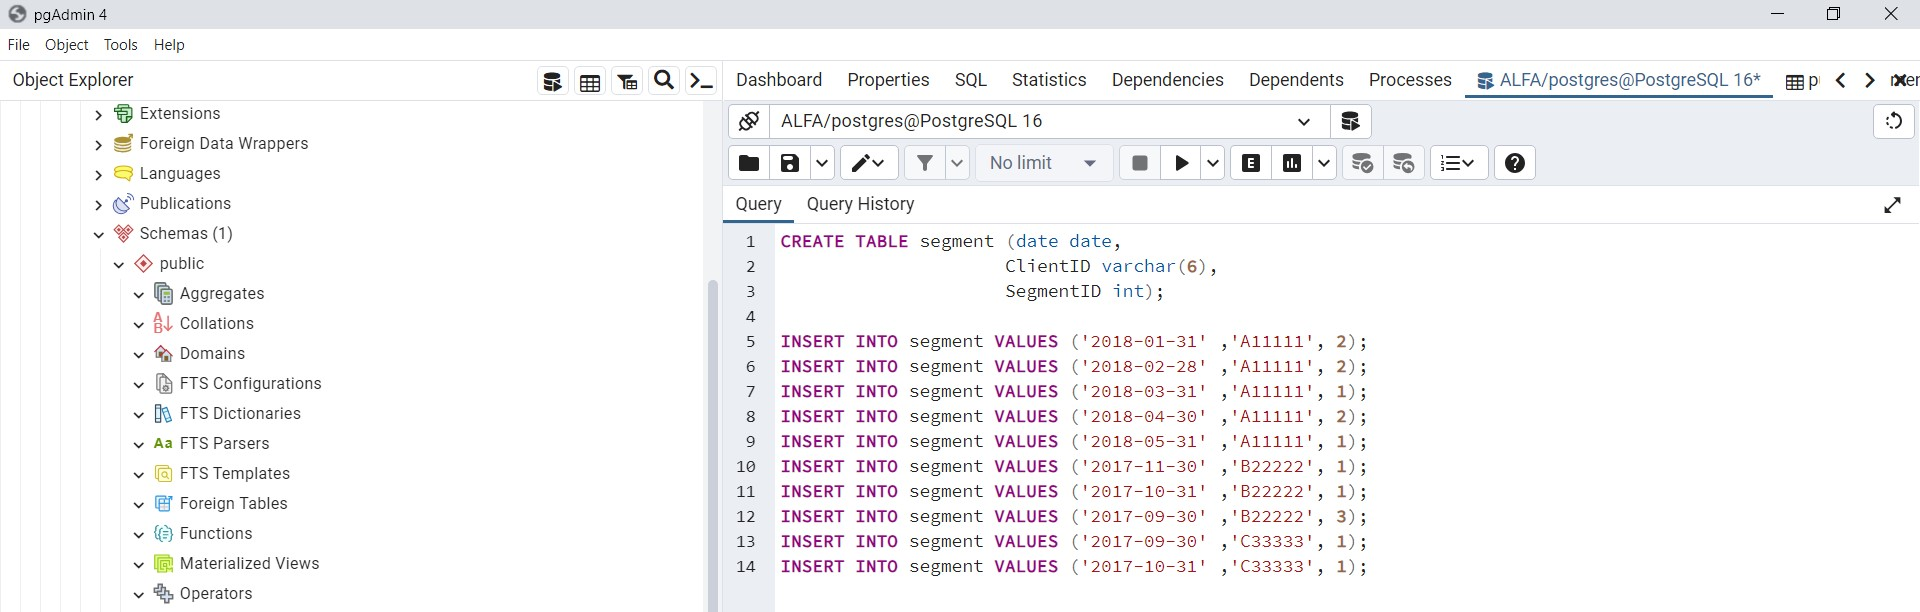

<font color='green'>**Даны месячные срезы сегментов клиентов, нужно получить по каждому клиенту периоды действия каждого сегмента.**</font>
____________________________

* create table #segment ([date] date, ClientID varchar(6),SegmentID int)
* insert into #segment values
* ('2018-01-31' ,'A11111', 2),
* ('2018-02-28' ,'A11111', 2),
* ('2018-03-31' ,'A11111', 1),
* ('2018-04-30' ,'A11111', 2),
* ('2018-05-31' ,'A11111', 1),
* ('2017-11-30' ,'B22222', 1),
* ('2017-10-31' ,'B22222', 1),
* ('2017-09-30' ,'B22222', 3),
* ('2017-09-30' ,'C33333', 1),
* ('2017-10-31' ,'C33333', 1)

In [12]:
%%time
with engine.begin() as conn:
    query = text("""SELECT * 
                    FROM segment""")
    s = pd.read_sql_query(query, conn)
s

CPU times: total: 0 ns
Wall time: 2 ms


date clientid  segmentid
0  2018-01-31   A11111          2
1  2018-02-28   A11111          2
2  2018-03-31   A11111          1
3  2018-04-30   A11111          2
4  2018-05-31   A11111          1
5  2017-11-30   B22222          1
6  2017-10-31   B22222          1
7  2017-09-30   B22222          3
8  2017-09-30   C33333          1
9  2017-10-31   C33333          1

## <font color='red'> запрос для 4-го задания SQL <a id='1041'></a>

In [13]:
%%time
with engine.begin() as conn:
    query = text("""WITH a1 AS(
                                --Начальные и конечные даты для каждого сегмента клиента
                                SELECT *,
                                        MIN(date) OVER (PARTITION BY ClientID, SegmentID ORDER BY date) AS start_date,
                                        MAX(date) OVER (PARTITION BY ClientID, SegmentID ORDER BY date) AS end_date,
                                        DENSE_RANK() OVER (PARTITION BY ClientID, segmentid ORDER BY segmentid, date) AS rn
                                FROM segment
                                ORDER BY clientid, segmentid, date),
                                
                                --таблица с уникальными начальной и конечной датами для каждого клиента и сегмента
                        a2 AS(
                                SELECT clientid, 
                                segmentid, 
                                MIN(start_date) AS start_date, 
                                MAX(end_date) AS end_date
                                FROM a1
                                GROUP BY clientid, segmentid),
                                
                                --Не знаю подразумевает ли задание, что если конца у периода нет, 
                                --то по сегодняшнюю дату период длится, 
                                --на всякий случай написала ;)
                        a3 AS(
                                SELECT s.date, 
                                        s.clientid, 
                                        s.segmentid, 
                                        a2.start_date, 
                                CAST(CASE WHEN a2.start_date = a2.end_date THEN now() ELSE a2.end_date END AS date) AS end_date
                                FROM segment s
                                LEFT JOIN a2 ON s.clientid = a2.clientid AND s.segmentid = a2.segmentid)

--добавила еще период в днях на всякий случай ;)
SELECT date, 
        clientid, 
        segmentid, 
        start_date, 
        end_date, 
        end_date - start_date AS day_period
FROM a3
                """)
    rez4 = pd.read_sql_query(query, conn)
rez4

CPU times: total: 0 ns
Wall time: 3 ms


date clientid  segmentid  start_date    end_date  day_period
0  2018-01-31   A11111          2  2018-01-31  2018-04-30          89
1  2018-02-28   A11111          2  2018-01-31  2018-04-30          89
2  2018-03-31   A11111          1  2018-03-31  2018-05-31          61
3  2018-04-30   A11111          2  2018-01-31  2018-04-30          89
4  2018-05-31   A11111          1  2018-03-31  2018-05-31          61
5  2017-11-30   B22222          1  2017-10-31  2017-11-30          30
6  2017-10-31   B22222          1  2017-10-31  2017-11-30          30
7  2017-09-30   B22222          3  2017-09-30  2024-03-07        2350
8  2017-09-30   C33333          1  2017-09-30  2017-10-31          31
9  2017-10-31   C33333          1  2017-09-30  2017-10-31          31

## <font color='blue'> Задание 2 - разметка и метрики. <a id='200'></a>

**РАЗМЕТКА И МЕТРИКИ**
- Партнерская витрина - это набор предложений партнеров банка, которые предоставляют различного рода скидки нашим клиентам.

* На витрину можно перейти разными способами: через внешние и внутренние коммуникации (SMS, email, push, баннеры/уведомления внутри приложения).
* Партнеры могут предоставлять данные о совершенных нашими клиентами конверсиях (транзакциях).

* ● Какие наборы метрик для оценки эффективности партнерской витрины вы можете предложить?
* ● Какие из них рекомендуете выбрать как основные, чтобы дать оценку этому продукту? И почему?
* ● Разметка каких событий вам понадобится?
* ● Какую информацию необходимо передавать в событиях?
* ● Какие гипотезы мы можем проверить, чтобы улучшить наши основные показатели?

## <font color='red'> Ответ на 2-й вопрос <a id='201'></a>

Для оценки эффективности партнерской витрины в качестве основных метрик можно рассмотреть следующие:

1. **Количество переходов** на партнерскую витрину из различных источников (SMS, email, push, баннеры/уведомления внутри приложения). Следовательно, сможем посчитать **DAU и MAU** с сегментацией по источникам.
2. **Конверсия** с перехода на партнерскую витрину в совершение транзакции.

- Если будет финансовая информация то:
3. **Средний чек** транзакции клиентов, перешедших на партнерскую витрину.
4. **Lifetime** - сколько пользователь "живет" в приложении.
5. Если будут предыдущие метрики, то конечно можно посчитать одну из важнейших метрик - **LTV (выручка за время жизни)**.

- Добавочные:
6. **ARPDAU, ARPPDAU, ARPMAU и ARPPMAU** - средняя выручка с активного пользователя в день/месяц и средняя выручка с активного платящего пользователя в день.
7. Если есть возможность проводить опросы пользователей или краткое анкетирование - то **индекс потребительской лояльности — NPS**.


Важно разметить события:
- Переход на партнерскую витрину по источникам.
- Совершение транзакции после перехода на партнерскую витрину.
- Использование конкретного предложения от партнера.

В событиях необходимо передавать информацию:
- о клиенте (идентификатор), 
- дате и времени события, 
- типе события (переход на витрину, совершение транзакции, использование предложения),
- деталях события (название партнера, тип предложения и т.д.).

Для улучшения основных показателей можно проверить следующие **гипотезы**:
1. Оптимизация контента и дизайна партнерской витрины для увеличения конверсии.
2. Тестирование различных способов коммуникации (SMS, email, push, баннеры/уведомления внутри приложения) для определения наиболее эффективного канала привлечения клиентов.
3. Анализ предпочтений клиентов в выборе предложений от партнеров для улучшения персонализации.

## <font color='blue'>Задание 3 - когортный анализ. <a id='300'></a>

* В приложенном файле хранятся данные об активности клиентов с сентября 2021 года по февраль 2022.
* Необходимо на основе этих данных провести когортный анализ CSV файла (sep = ;)
___________________________
* Описание полей:
* **CLIENT_ID** - идентификатор клиента;
* **VALUE_DAY** - дата авторизации в мобильное приложение за последние 30 дней;
_______________________________
* ● Постройте визуальное представление когорты по месяцам, которая покажет, как удерживаются клиенты после их первого посещения мобильного приложения;
* ● Какие гипотезы такого поведения можно предположить? Как их можно проверить?
* ● Какими способами можно улучшить ситуацию?

<font color='red'> **Посчитала разными способами - были расчеты на Python оставила их просто для примера**  
* **в процессе выявила пользователя у которого по 2 посещения в месяц записано,** 
* **исключила его для чистоты эксперимента, расчеты на python просто для примера,**
* **решила основным сделать расчет метрик на SQL**

In [14]:
%%time
# Загрузка данных из файла dataset.csv
df = pd.read_csv('dataset.csv', sep = ';', header=0)
df = df[['CLIENT_ID', 'VALUE_DAY']]

# Преобразование поля value_day в формат даты
df['VALUE_DAY'] = pd.to_datetime(df['VALUE_DAY'])

# месяц и год
df['cohort_month'] = df['VALUE_DAY'].dt.to_period('M')

#далее продолжим без этого пользователя
df1 = df.query('CLIENT_ID != 1813118018')

#найдем первую дату посещения
df_first = df1.groupby('CLIENT_ID')['VALUE_DAY'].min().reset_index()
df_first.columns = ['CLIENT_ID', 'first_date']

#присоединим к исходной таблице
df1 = df1.merge(df_first, on='CLIENT_ID', how = 'left')

#первый месяц посещения
df1['first_month'] = df1['first_date'].dt.to_period('M')
#df1.sample(5)

<timed exec>:6: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



CPU times: total: 609 ms
Wall time: 612 ms


In [15]:
#Количество визитов пользователя в месяц
df2 = df1.pivot_table(index=['CLIENT_ID', 'cohort_month'], values='VALUE_DAY', aggfunc='nunique').reset_index()

#количество посещений за весь период 
df3 = df2.pivot_table(index=['CLIENT_ID'], 
                      columns = 'cohort_month', 
                      values='VALUE_DAY', 
                      aggfunc='sum', 
                      margins= True , 
                      margins_name='lifetime',
                      fill_value = 0).reset_index()
df3 = df3[:-1]
#df3.tail(10)

In [16]:
#справочник с количеством уникальных посетителей за каждый месяц
df4 = df3.pivot_table(index=['lifetime'], values='CLIENT_ID', aggfunc='nunique').reset_index()
df4.columns = ['pos', 'unique_users']
df4['life'] = range(5, -1, -1)

def datk(num):
    if num == 0:
        return '2021-09'
    if num == 1:
        return '2021-10'
    if num == 2:
        return '2021-11'
    if num == 3:
        return '2021-12'
    if num == 4:
        return '2022-01'
    elif num == 5:
        return '2022-02'
    
df4['first_month'] = df4['life'].apply(datk)
df4['first_month'] = pd.to_datetime(df4['first_month'])
df4['first_month'] = df4['first_month'].dt.to_period('M')

#прибавим количество визитов каждый месяц
df5 = df2.pivot_table(index=['cohort_month'], values='VALUE_DAY', aggfunc='sum').reset_index()
df5.columns = ['first_month', 'MAU']
df5 = df4.merge(df5, on='first_month', how = 'left')

#универсальная таблица со всеми показателями
df6 = df5[['first_month', 'unique_users', 'MAU']]
df6 = df1.merge(df6, on='first_month', how = 'left')

#вычисление новых пользователей
df6['type_users'] = np.where(df6['first_month'] == df6['cohort_month'], 'Новые', 'Вернувшиеся')

#добавим lifetime (время жизни в месяцах) каждого клиента
df3 = df3[['CLIENT_ID', 'lifetime']]
df6 = df6.merge(df3, on='CLIENT_ID', how = 'left')
#df6.tail(7)

In [17]:
gc.collect()

2173

## <font color='red'> Ответ на 3-й вопрос <a id='301'></a>

Tаблица была добавлена в базу Postgres

## Средний lifetime

In [18]:
%%time
with engine.begin() as conn:
    query = text("""
    WITH first_values AS (
-- Добавление даты первого использования
SELECT *, 
       FIRST_VALUE(value_date) OVER (PARTITION BY client_id ORDER BY value_date) AS first_date
FROM cohort
WHERE client_id != '1813118018'),

activity AS (
    -- Расчёт числа удержанных пользователей для каждого лайфтайма 

    SELECT 'Все месяцы' AS first_date,
           ROUND((value_date - first_date)/29.8) AS lifetime, 
           COUNT(DISTINCT client_id) AS retained
    FROM first_values
    GROUP BY value_date - first_date
),

retention AS (
    -- Расчёт доли удержания
    SELECT first_date, lifetime, retained,
           SUM(CASE WHEN lifetime = 0 THEN retained ELSE 0 END) \
           OVER (PARTITION BY first_date) AS cohort_size,
           CAST(retained AS FLOAT) / SUM(CASE WHEN lifetime = 0 THEN retained ELSE 0 END) \
           OVER (PARTITION BY first_date) AS retention_rate
    FROM activity 
    ORDER BY first_date, lifetime
) 

-- Финальная фильтрация и интегрирование
SELECT first_date, 
       SUM(retention_rate) AS mean_lifetime 
FROM retention
WHERE lifetime <= 5
GROUP BY first_date 
""")
    mean_lifetime = pd.read_sql_query(query, conn)
mean_lifetime

CPU times: total: 0 ns
Wall time: 13.6 s


first_date  mean_lifetime
0  Все месяцы       4.765558

### LIFETIME

In [19]:
%%time
with engine.begin() as conn:
    query = text("""
    WITH first_values AS (
-- Добавление даты первого использования и убираем проблемного клиента
SELECT *, 
       FIRST_VALUE(value_date) OVER (PARTITION BY client_id ORDER BY value_date) AS first_date
FROM cohort
WHERE client_id != '1813118018'),

activity AS (
--Расчёт числа удержанных пользователей для каждого лайфтайма */
    SELECT first_date,
           ROUND((value_date - first_date)/29.8) AS lifetime, 
           COUNT(DISTINCT client_id) AS retained
    FROM first_values
    GROUP BY first_date, value_date - first_date
)
--Расчёт доли удержания
    SELECT first_date, lifetime, retained,
           SUM(CASE WHEN lifetime = 0 THEN retained ELSE 0 END) \
           OVER (PARTITION BY first_date) AS cohort_size,
           CAST(retained AS FLOAT) / SUM(CASE WHEN lifetime = 0 THEN retained ELSE 0 END) \
           OVER (PARTITION BY first_date) AS retention_rate
    FROM activity 
    ORDER BY first_date, lifetime
    """)
    lifetime = pd.read_sql_query(query, conn)
lifetime

CPU times: total: 15.6 ms
Wall time: 12.9 s


first_date  lifetime  retained  cohort_size  retention_rate
0   2021-09-30       0.0    129231     129231.0        1.000000
1   2021-09-30       1.0    124592     129231.0        0.964103
2   2021-09-30       2.0    120231     129231.0        0.930357
3   2021-09-30       3.0    116455     129231.0        0.901138
4   2021-09-30       4.0    105546     129231.0        0.816724
5   2021-09-30       5.0    104162     129231.0        0.806014
6   2021-10-31       0.0      7044       7044.0        1.000000
7   2021-10-31       1.0      6936       7044.0        0.984668
8   2021-10-31       2.0      6883       7044.0        0.977144
9   2021-10-31       3.0      5040       7044.0        0.715503
10  2021-10-31       4.0      4800       7044.0        0.681431
11  2021-11-30       0.0      5841       5841.0        1.000000
12  2021-11-30       1.0      5743       5841.0        0.983222
13  2021-11-30       2.0      5225       5841.0        0.894539
14  2021-11-30       3.0      4377       5841.0        0.749358
15  2021-12-31       0.0      6875       6875.0        1.000000
16  2021-12-31       1.0      6188       6875.0        0.900073
17  2021-12-31       2.0      6170       6875.0        0.897455
18  2022-01-31       0.0     14770      14770.0        1.000000
19  2022-01-31       1.0     14374      14770.0        0.973189
20  2022-02-28       0.0      5330       5330.0        1.000000

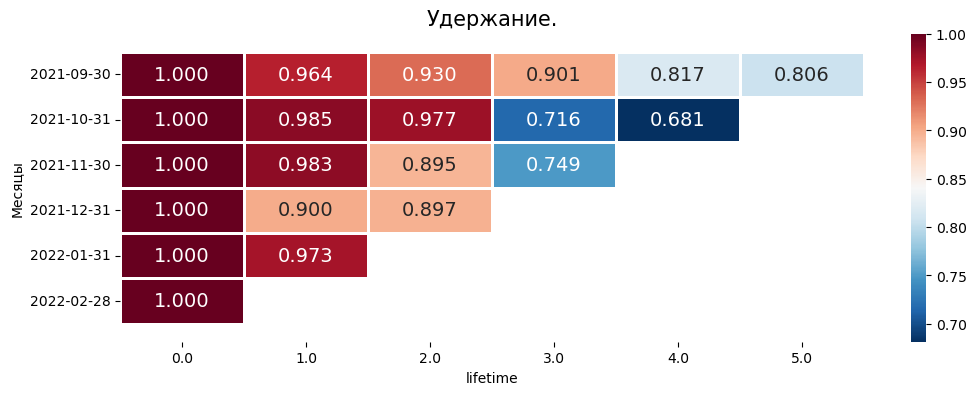

In [20]:
churn_age_salmean = lifetime.pivot_table(index=['first_date'], columns=['lifetime'], values='retention_rate', aggfunc='sum')
plt.figure(figsize=(12, 4))
plt.title('Удержание.', fontsize=15) 
ax = sns.heatmap(churn_age_salmean, annot=True, fmt='.3f', linewidths=1, 
                 linecolor='white', cmap='RdBu_r', annot_kws={'size': 14},)
i, k = ax.get_ylim()
ax.set_ylim(i+0.4, k-0.4)
plt.ylabel('Месяцы')
plt.show()

### Средний retention

In [21]:
%%time
with engine.begin() as conn:
    query = text("""
    WITH first_values AS (
-- Добавление даты первого использования
SELECT *, 
       FIRST_VALUE(value_date) OVER (PARTITION BY client_id ORDER BY value_date) AS first_date
FROM cohort
WHERE client_id != '1813118018'),

activity AS (
    -- Расчёт числа удержанных пользователей для каждого лайфтайма 

    SELECT 'Все месяцы' AS first_date,
           ROUND((value_date - first_date)/29.8) AS lifetime, 
           COUNT(DISTINCT client_id) AS retained
    FROM first_values
    GROUP BY value_date - first_date
),
--Расчет удержания
retention AS
  (SELECT lifetime,
          retained,
          SUM(CASE WHEN lifetime = 0 THEN retained ELSE 0 END) OVER (PARTITION BY first_date)  AS cohort_size,
          CAST(retained AS FLOAT) / SUM(CASE WHEN lifetime = 0 THEN retained ELSE 0 END) OVER (PARTITION BY first_date)  AS retention_rate
   FROM activity),
--Промежуточный расчет
ret AS (
	SELECT *
	FROM retention
	ORDER BY retention_rate DESC)
--Расчет среднего retention по LT
SELECT lifetime, SUM(retention_rate) AS mean_retention_rate
FROM retention
GROUP BY lifetime
ORDER BY mean_retention_rate
""")
    mean_retention = pd.read_sql_query(query, conn)
mean_retention

CPU times: total: 0 ns
Wall time: 13.3 s


lifetime  mean_retention_rate
0       5.0             0.616011
1       4.0             0.652584
2       3.0             0.744404
3       2.0             0.819139
4       1.0             0.933420
5       0.0             1.000000

(0.0, 1.0)

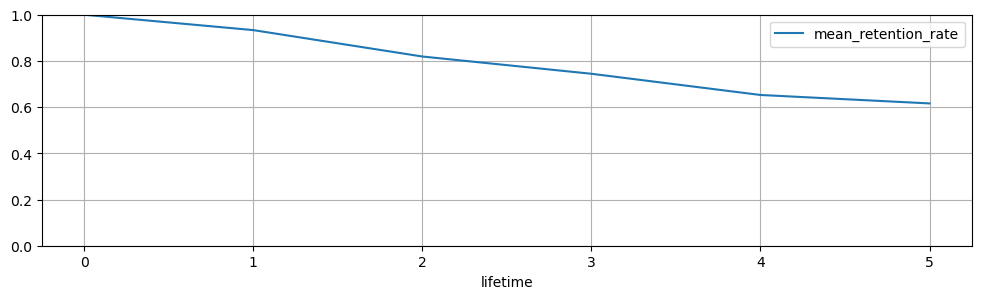

In [22]:
#потребности в количестве минут по тарифам:
c1 = mean_retention.pivot_table(index='lifetime', values='mean_retention_rate', aggfunc='sum')
c1.plot(grid=True, figsize=(12, 3))
plt.ylim(0, 1)

### MAU - по месяцам

In [23]:
%%time
with engine.begin() as conn:
    query = text("""SELECT value_date,
       COUNT(DISTINCT client_id) AS uniques
FROM cohort
WHERE client_id != '1813118018'
GROUP BY value_date 
""")
    mau = pd.read_sql_query(query, conn)
mau['lag_mau'] = mau['uniques'].shift(1).fillna(0)
mau['perc_mau'] = (mau['uniques'] - mau['lag_mau'])/(mau['lag_mau']/100)
mau

CPU times: total: 15.6 ms
Wall time: 7.08 s


value_date  uniques   lag_mau  perc_mau
0  2021-09-30   129231       0.0       inf
1  2021-10-31   131636  129231.0  1.861009
2  2021-11-30   133008  131636.0  1.042268
3  2021-12-31   135956  133008.0  2.216408
4  2022-01-31   136769  135956.0  0.597988
5  2022-02-28   139213  136769.0  1.786955

(100000.0, 150000.0)

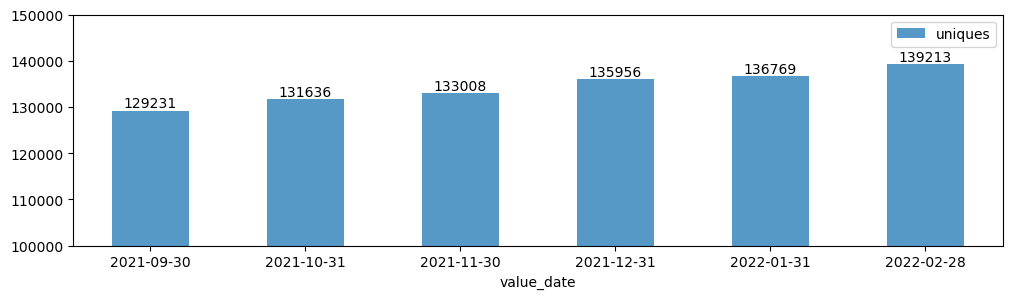

In [24]:
ax = mau.plot(y='uniques', x = 'value_date', kind='bar', figsize=(12, 3), alpha=0.75, rot=0, fontsize = 10)
ax.bar_label(ax.containers[0])
plt.ylim(100000, 150000)

### Прирост

(0.0, 10.0)

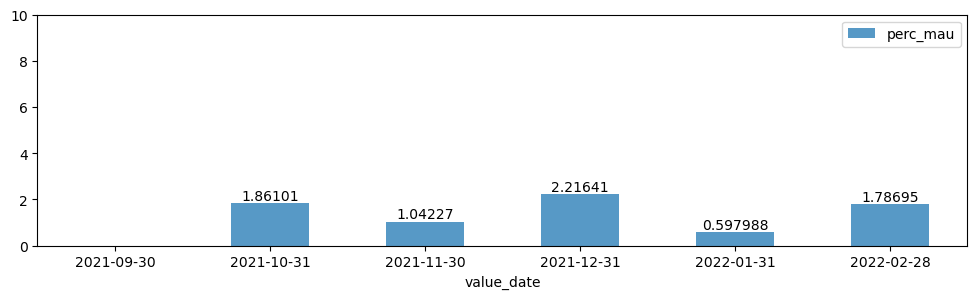

In [25]:
ax = mau.plot(y='perc_mau', x = 'value_date', kind='bar', figsize=(12, 3), alpha=0.75, rot=0, fontsize = 10)
ax.bar_label(ax.containers[0])
plt.ylim(0, 10)

### Доли новых пользователей

In [26]:
%%time
with engine.begin() as conn:
    query = text("""
    WITH first_values AS (
-- Добавление даты первого использования
SELECT *, 
       FIRST_VALUE(value_date) OVER (PARTITION BY client_id ORDER BY value_date) AS first_date
FROM cohort
WHERE client_id != '1813118018'),

mau AS (
--Расчёт MAU
SELECT value_date, 
      CASE WHEN first_date = value_date THEN 'Новые пользователи' ELSE 'Старые пользователи' END AS new_old, 
      COUNT(DISTINCT client_id) AS uniques 
FROM first_values 
GROUP BY value_date, 
        CASE WHEN first_date = value_date THEN 'Новые пользователи' ELSE 'Старые пользователи' END 
    ORDER BY value_date, uniques DESC
),

perc_mau AS (    
    --Расчёт долей MAU 
SELECT value_date,
       new_old,
       uniques,
       SUM(uniques) OVER (PARTITION BY value_date) AS total_mau,                          -- общий MAU в текущий месяц
       CAST(uniques AS FLOAT) / SUM(uniques) OVER (PARTITION BY value_date) AS perc_mau   -- доля от общего MAU
FROM mau  
)

--Финальная фильтрация
SELECT * 
FROM perc_mau
WHERE new_old = 'Новые пользователи' 
""")
    new_users = pd.read_sql_query(query, conn)
new_users

CPU times: total: 0 ns
Wall time: 15.3 s


value_date             new_old  uniques  total_mau  perc_mau
0  2021-09-30  Новые пользователи   129231   129231.0  1.000000
1  2021-10-31  Новые пользователи     7044   131636.0  0.053511
2  2021-11-30  Новые пользователи     5841   133008.0  0.043915
3  2021-12-31  Новые пользователи     6875   135956.0  0.050568
4  2022-01-31  Новые пользователи    14770   136769.0  0.107992
5  2022-02-28  Новые пользователи     5330   139213.0  0.038287

[Text(0, 0, '1'),
 Text(0, 0, '0.0535112'),
 Text(0, 0, '0.0439147'),
 Text(0, 0, '0.0505678'),
 Text(0, 0, '0.107992'),
 Text(0, 0, '0.0382867')]

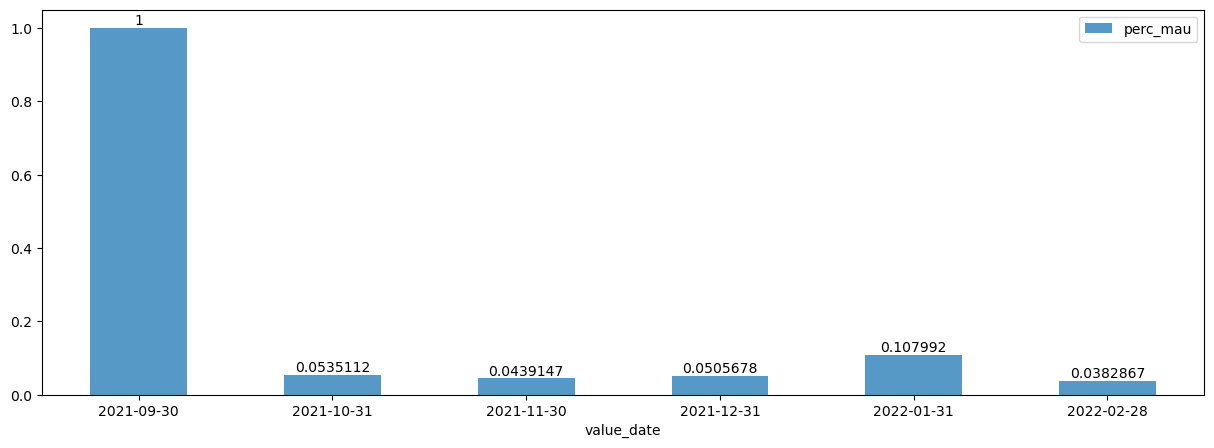

In [27]:
ax = new_users.plot(y='perc_mau', x = 'value_date', kind='bar', figsize=(15, 5), alpha=0.75, rot=0)
ax.bar_label(ax.containers[0])

### <font color='red'> Выводы и рекомендации к 3-му вопросу: <a id='302'></a>

Новые пользователи составляют всего 3-5% от MAU. Можно сказать, что аудитория проекта держится в основном на «старичках». 
Но есть "всплеск" в 2 раза на новогодние праздники, или это традиционное поведение пользователей (все тратят подаренные деньги ;), или можно говорить о хорошо проведенных новогодних акциях. После нового года спад, чуть больше чем обычные показатели (всё потратили ;).

Метрика MAU растет от месяца к месяцу, активность аудитории растет в среднем на 1.5% в месяц но! именно MAU имеет сезонность: зимой MAU растёт из-за новогодних праздников, летом падает из-за традиционных летних отпусков.  Если была бы DAU (без рекламных кампаний и активных улучшений) она монотонно немного падает. Но нужно отметить, что в декабре всплеск активности аудитории - рост 2,2% к предыдущему месяцу, а в январе рост уже меньше, чем в другие месяцы - 0,6% по отношению к предыдущему (компенсация декабря).

В среднем новый пользователь "живет" в приложении - 4.8 месяцев - хороший показатель.

Из всех пользователей вернулись к концу периода (6 мес) - 61%.

Наблюдается тренд на падение retention rate (удержания) от - но это обычное поведение метрики. Продукт со временем устаревает.
Это неизбежно случается с любым продуктом. Приходят конкуренты - у хороших продуктов часто появляются аналоги. Исчерпывается аудитория.

**Падение retention rate пользования приложением может иметь различные причины:**

1. Недостаточно удовлетворительный пользовательский опыт: 
- если приложение неудобно использовать, 
- оно имеет ошибки или не соответствует ожиданиям пользователей.

2. Отсутствие ценности для пользователей: 
- если приложение не решает проблему пользователя.

3. Недостаточная маркетинговая стратегия: 
- если приложение недостаточно продвигается или не привлекает новых пользователей.

4. Конкуренция на рынке: 
- если на рынке появляются новые конкуренты с более привлекательными предложениями, пользователи могут перейти к ним.

**Для увеличения retention rate можно предпринять следующие действия:**

1. Улучшить пользовательский опыт: 
- исправить ошибки, 
- упростить навигацию, 
- добавить новые функции,
- улучшить дизайн.

2. Повысить ценность приложения: 
- добавить новые полезные функции,
- улучшить качество контента,
- применить персонализированный подход к пользователям.

3. Усилить маркетинговые усилия: 
- провести рекламную кампанию, 
- запустить акции и специальные предложения для привлечения новых пользователей и удержания текущих,
- выяснить не было ли неудачных рекламных акций.

4. Изучить конкурентов: 
- выявить их сильные и слабые стороны, чтобы улучшить свое приложение и привлечь больше пользователей.

5. Слушать обратную связь пользователей: 
- внимательно изучать отзывы пользователей, 
- учитывать их пожелания и предложения для улучшения приложения.

## <font color='blue'> Задание 4 - портфолио. <a id='400'></a>

* Мини-портфолио по 2-3 сделанным вами ранее отчетам/исследованиям (чувствительную информацию можете упустить и “заблюрить” значения если прикладываете скрины отчетов):
* ● какая цель и задачи стояли, какие пользователи результата,
* ● для исследований - какие методы и инструменты были выбраны,
* ● опишите источники данных, требовались ли доработки в источниках для обеспечения полноты данных и для матчинга,
* ● какие инструменты использовались для выгрузки данных из источников и для их объединения, для автоматизации,
* ● каким образом производился матчинг данных разных систем-источников,
* ● какие средства визуализации использовались и каким образом выглядел конечный результат

## <font color='red'> 1 проект <a id='401'></a>

Требовались оперативные финансовые отчеты для финансового директора в Power BI c выгрузкой из 1С - без презентаций
- срезы видно на фото

если пришлете почту могу дать доступ в WEB-службу - там все интерактивно

здесь можно посмотреть видео https://disk.yandex.ru/d/RYj-C0teL6-Ytg

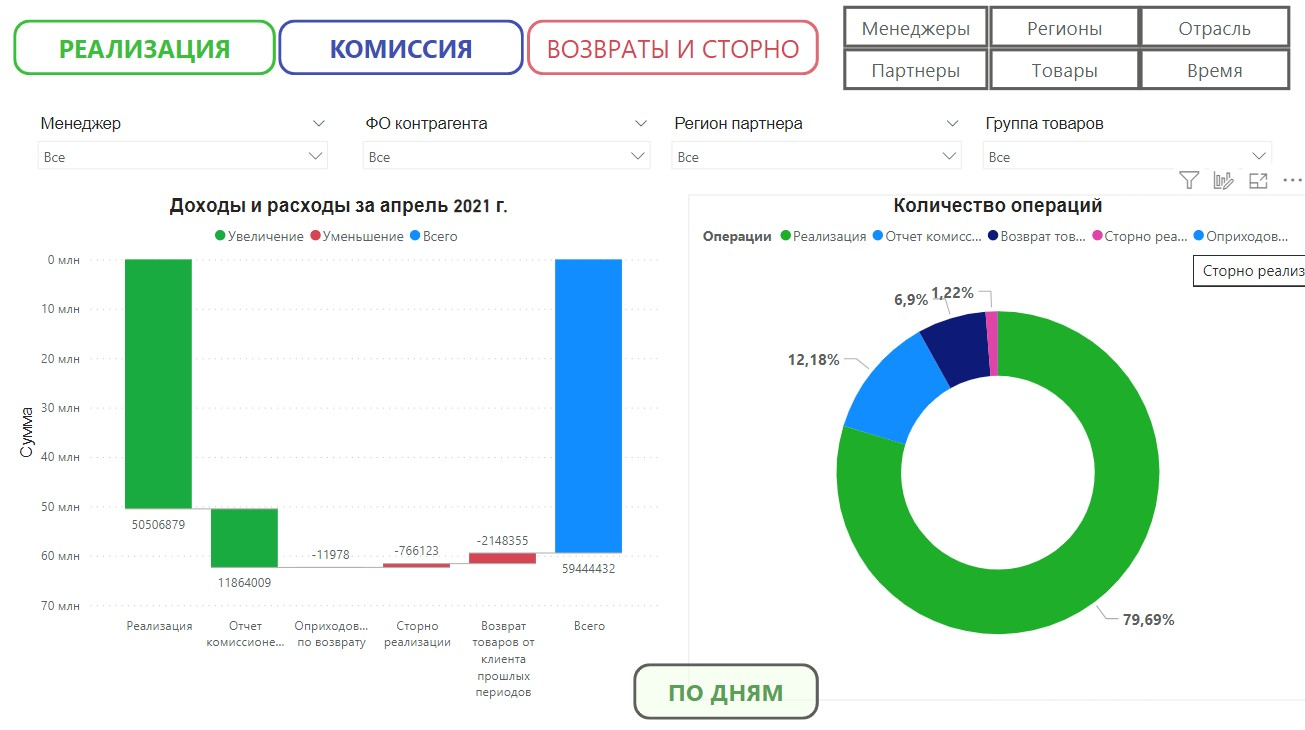

## <font color='red'> 2 проект <a id='402'></a>

- Данные компании изменены 
- разработка дашборда юнит-экономики для сервиса доставки еды
- цель - исследовать окупаемость новых пользователей продукта в первые семь дней их жизни, 
- для принятия решения о параметрах запуска рекламы на телевидении с целью оптимизации затрат.
- написаны SQL-запросы к БД Postgres,
- требовалась визуализация в Tableau и выводы,
- оформление выводов в презентации Power Point.

Дашборд - https://disk.yandex.ru/i/BNV9Roau1rQhHw

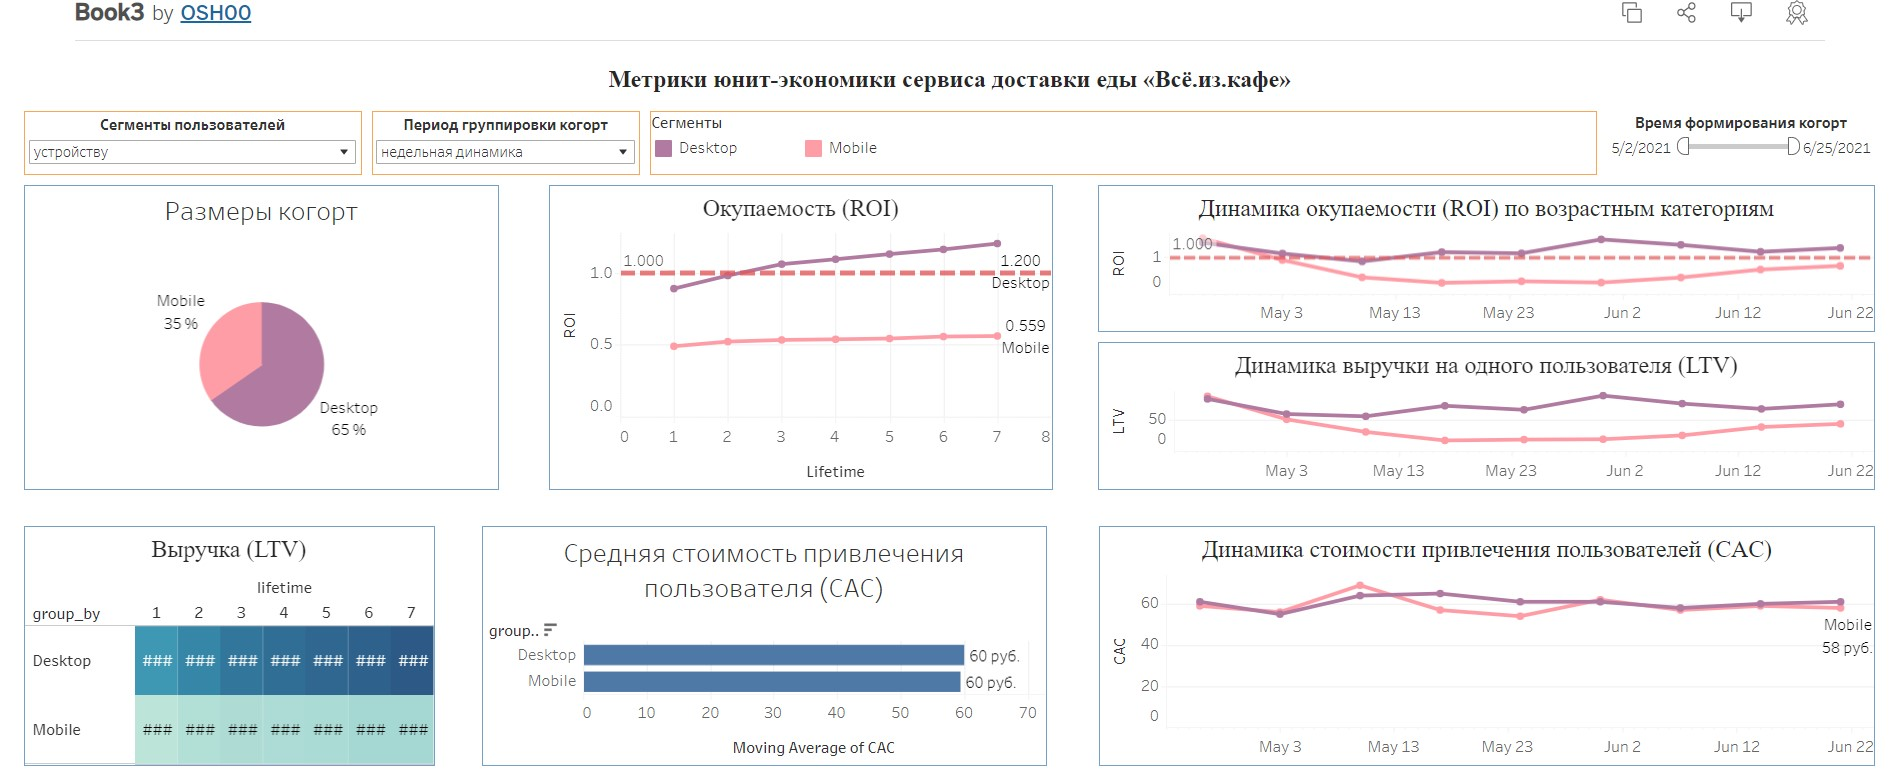

презентация результатов - https://disk.yandex.ru/i/BNV9Roau1rQhHw

## <font color='red'> 3 проект <a id='403'></a>

- Было тестовое для компании Медиаскоп - напишу о нем, т.к. были необычные отраслевые метрики, ну и получилось полноценное продуктовое исследование.
- ЗАДАНИЕ - https://disk.yandex.ru/i/p7EX0g07tfkNUw
- была куча таблиц не подходящих для исследования (специально), нужно было их преобразовать и выполнить задание

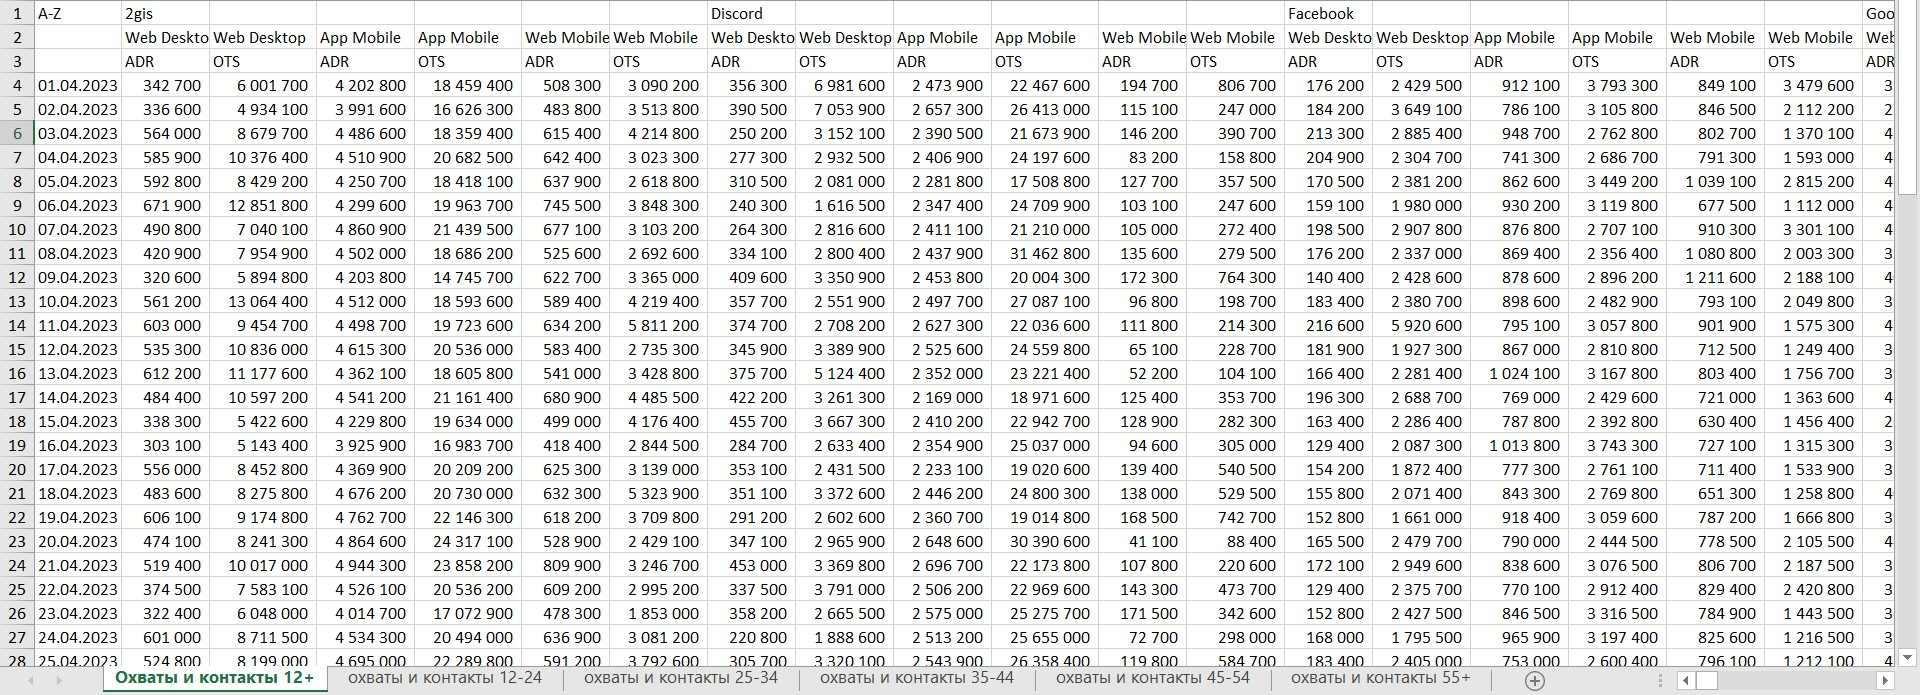

- (я выбрала сделать скрипт на Python, он преобразовал все в две плоские таблицы 
+ обогатила категориями своими, для удобства на графиках) 
+ сделала ABC категории, для одного исследования
+ процентные соотношения (новые метрики изобрела)

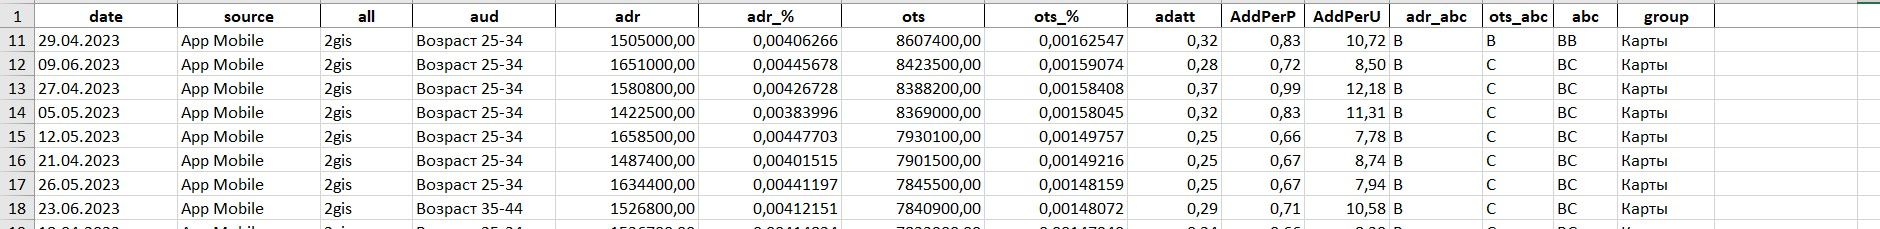

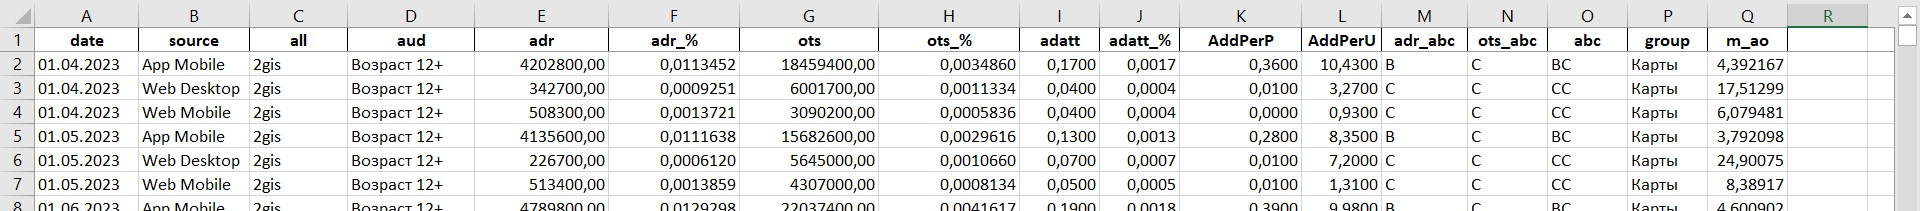

- сделала 3 дашборда в Tableau вытянула там, все, что можно было из данных 
* https://public.tableau.com/app/profile/osh00/viz/MEDIAS/Dashboard1?publish=yes
* https://public.tableau.com/app/profile/osh00/viz/MEDIAS/Dashboard1?publish=yes 
* https://public.tableau.com/app/profile/osh00/viz/MEDIAS/Dashboard3?publish=yes

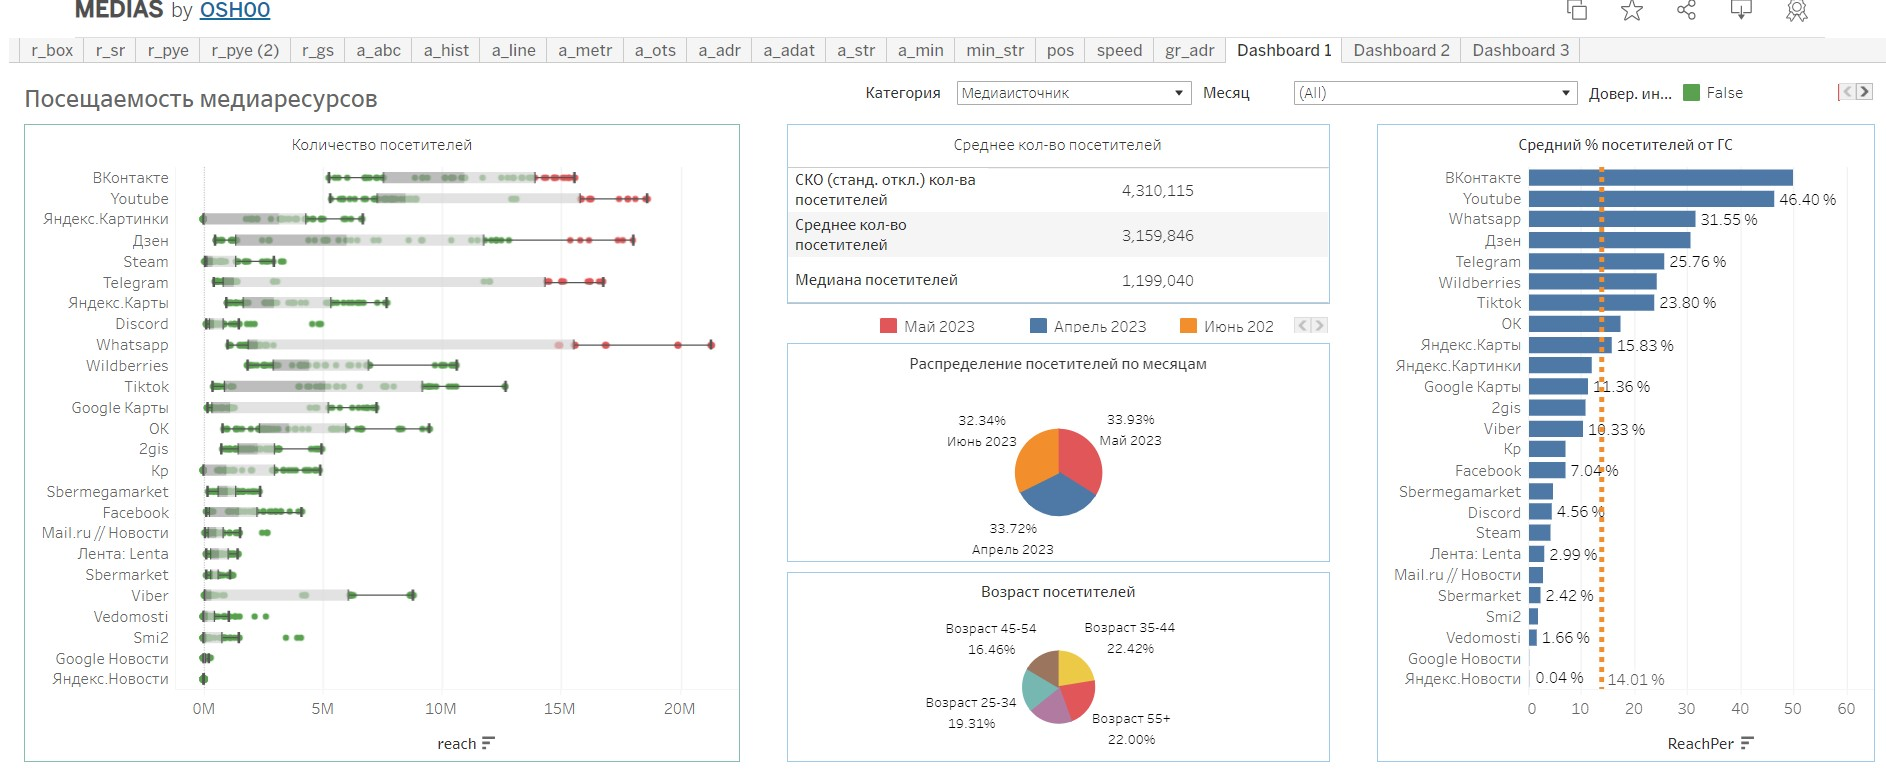

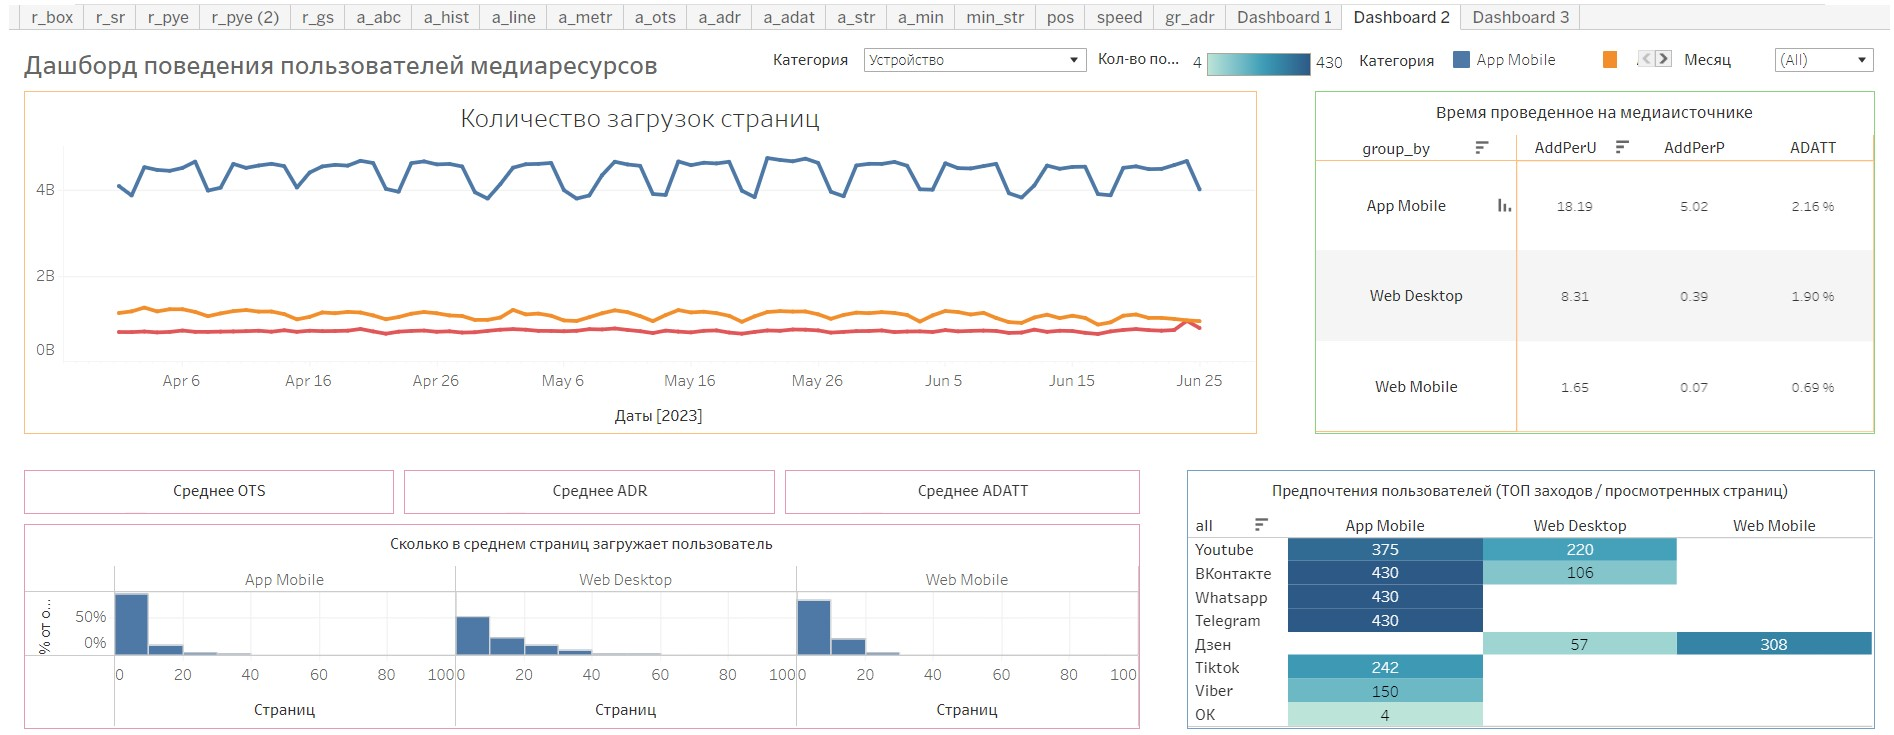

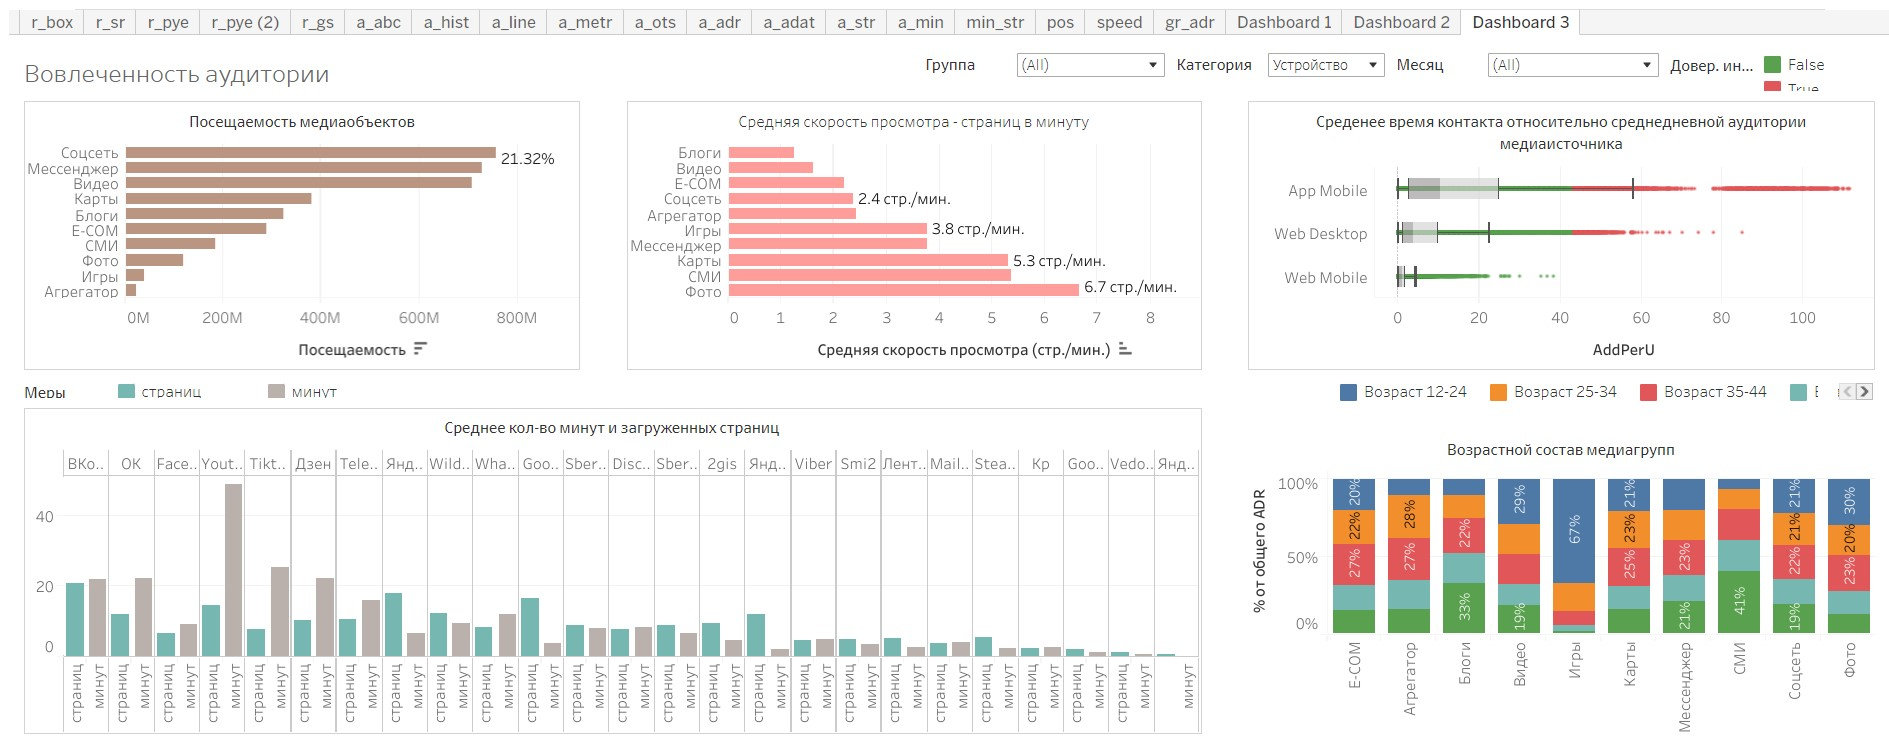

- и презентацию с ответами - https://disk.yandex.ru/i/hFjcmcr7JC5Ryg

## <font color='red'> 4 проект <a id='404'></a>

Заказ от руководителя отдела платных услуг (онкологический стационар)
- требовалось исследование данных за последний год
- выявить точки роста в разных сегментах по услугам, типам услуг, отделениям и территориальной принадлежности пациента
- сделать презентацию с рекомендациями
- сделала исследование на Python - данные из БД Postgres + SQL Server
- ABC + RFM анализ
- готовая презентация с рекомендациями по приложению маркетинговых усилий по определенным направлениям
- https://disk.yandex.ru/i/TKIGJIWyqwmbBA

## <font color='red'> 5 проект <a id='405'></a>

- ну и конечно мой любимый web-портал на Plotly Dash + Flask ;)
- все полностью написала сама - от исследования БД, преобразования - до технического исполнения, пришлось выучить разметку и стили))
- 21 дашборд
- пара страничек из него

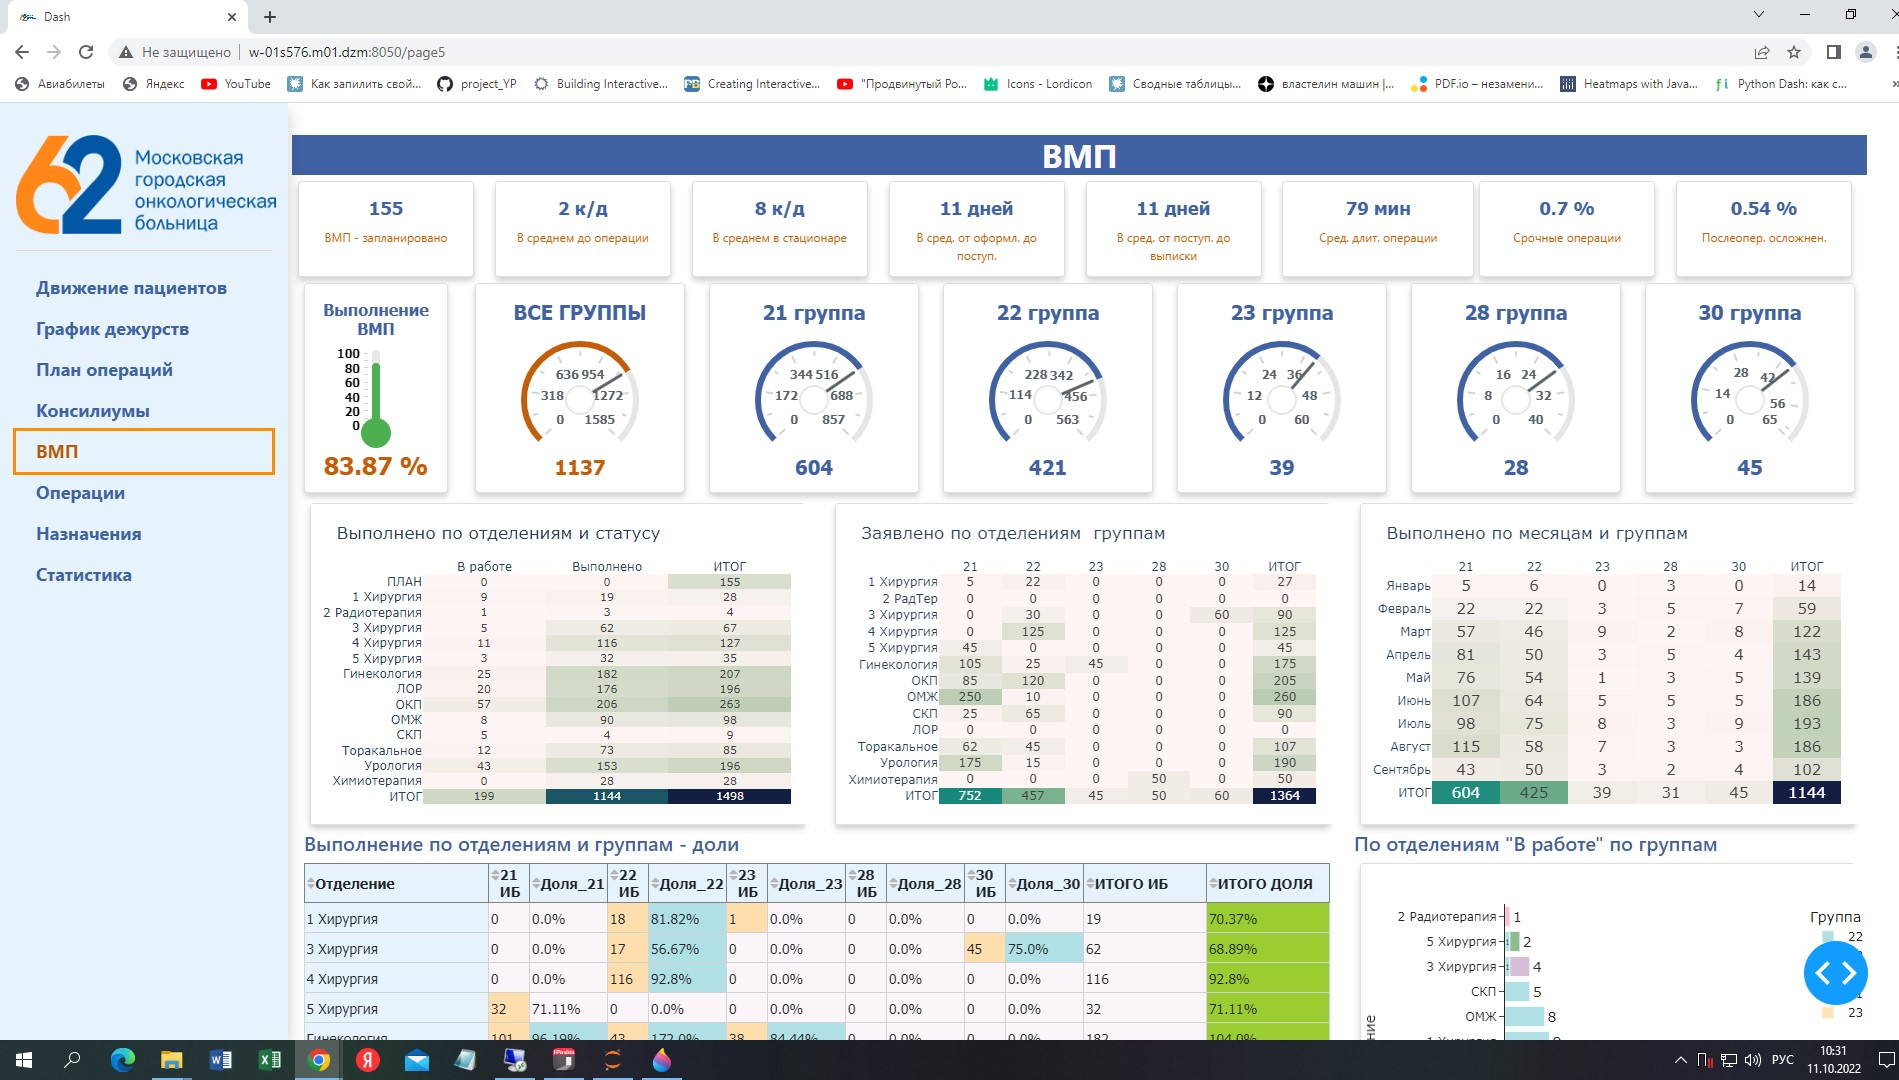

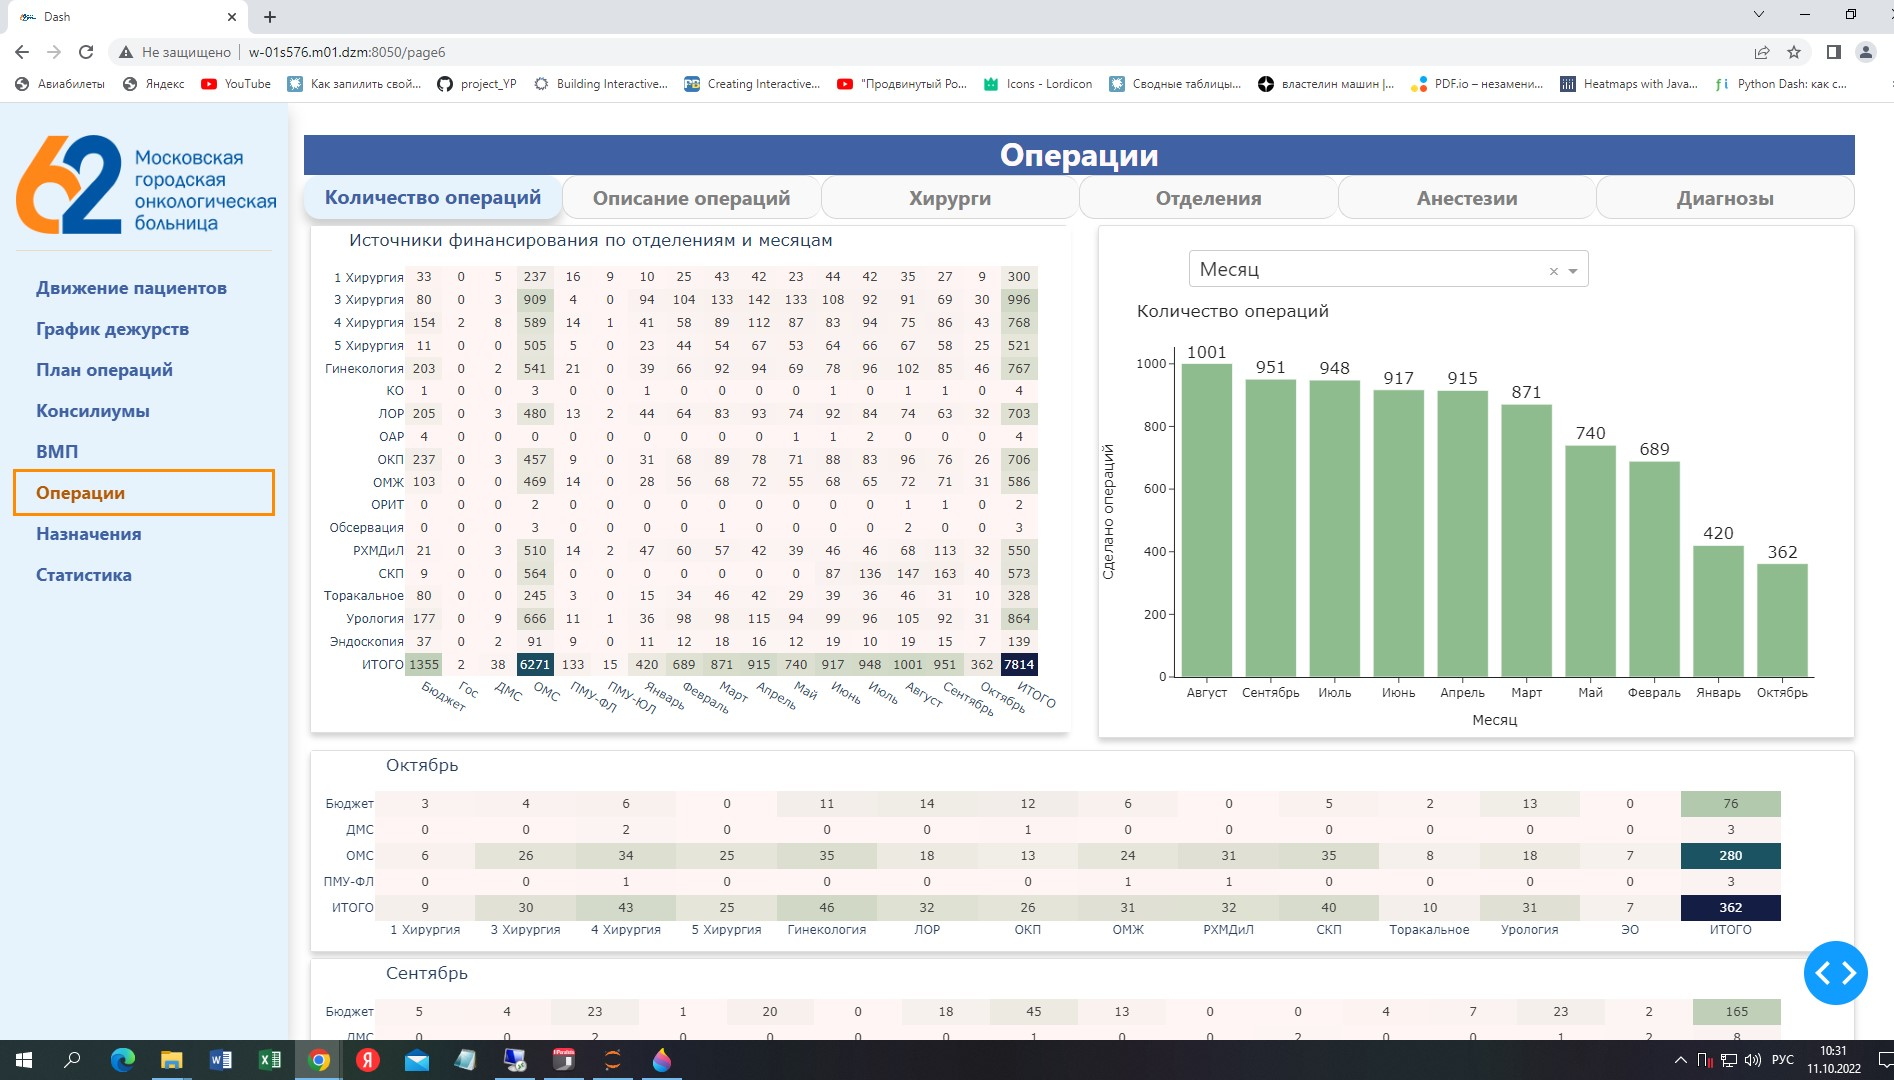